# Clustering

Σε αυτό το notebook πραγματοποιούμε μη επιβλεπόμενη ανάλυση κατηγοριοποίησης (clustering) χρησιμοποιώντας το σύνολο δεδομένων **Energy Efficiency Dataset** από το Kaggle.

Σύνδεσμος δεδομένων: https://www.kaggle.com/datasets/ujjwalchowdhury/energy-efficiency-data-set

## Περιγραφή

Το σύνολο δεδομένων περιλαμβάνει οκτώ μεταβλητές εισόδου που σχετίζονται με τα χαρακτηριστικά του κτιρίου (π.χ. επιφάνεια τοίχου, επιφάνεια οροφής, προσανατολισμός) και δύο μεταβλητές εξόδου:
- **Heating Load (Y1)**: η ποσότητα ενέργειας που απαιτείται για θέρμανση.
- **Cooling Load (Y2)**: η ενέργεια που απαιτείται για ψύξη.

Σε αυτό το αρχείο θα πραγματοποιήσουμε:
- Εξερευνητική Ανάλυση Δεδομένων (EDA)
- Επιλογή και κανονικοποίηση χαρακτηριστικών
- Προσδιορισμό του βέλτιστου αριθμού clusters με τη μέθοδο του αγκώνα (Elbow)
- Εφαρμογή του αλγορίθμου KMeans
- Οπτικοποίηση των αποτελεσμάτων σε 2D και σε 3D χώρο με τη βοήθεια του PCA


## 1. Εισαγωγή των απαραίτητων βιβλιοθηκών


In [184]:
# Εισαγωγή απαραίτητων βιβλιοθηκών
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import silhouette_score






## 2. Φόρτωση και συνοπτική περιγραφή των δεδομένων

Αρχικά γίνεται η φόρτωση του αρχείου `.csv` με το σύνολο δεδομένων και παρουσιάζεται συνοπτικά η μορφή του.  
Το σύνολο περιέχει 8 ποσοτικά χαρακτηριστικά που αφορούν τη γεωμετρία και μόνωση κτιρίων, καθώς και 2 μεταβλητές στόχους:

- Heating Load (συνεχής)
- Cooling Load (συνεχής)

Για τις ανάγκες της clustering, **θα χρησιμοποιηθούν μόνο τα 8 χαρακτηριστικά** (δηλ. χωρίς τις target variables).  



In [185]:
# Ανάγνωση δεδομένων
df = pd.read_csv("data/energy_efficiency_data.csv")

# Προεπισκόπηση
df.head()


,Relative_Compactness,Surface_Area,Wall_Area,Roof_Area,Overall_Height,Orientation,Glazing_Area,Glazing_Area_Distribution,Heating_Load,Cooling_Load
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28


In [186]:
# check for missing values
df.isnull().sum()


Relative_Compactness         0
Surface_Area                 0
Wall_Area                    0
Roof_Area                    0
Overall_Height               0
Orientation                  0
Glazing_Area                 0
Glazing_Area_Distribution    0
Heating_Load                 0
Cooling_Load                 0
dtype: int64

In [187]:
df.dtypes

Relative_Compactness         float64
Surface_Area                 float64
Wall_Area                    float64
Roof_Area                    float64
Overall_Height               float64
Orientation                    int64
Glazing_Area                 float64
Glazing_Area_Distribution      int64
Heating_Load                 float64
Cooling_Load                 float64
dtype: object

In [188]:
df.describe()

,Relative_Compactness,Surface_Area,Wall_Area,Roof_Area,Overall_Height,Orientation,Glazing_Area,Glazing_Area_Distribution,Heating_Load,Cooling_Load
count,768.000000,768.000000,768.000000,768.000000,768.00000,768.000000,768.000000,768.00000,768.000000,768.000000
mean,0.764167,671.708333,318.500000,176.604167,5.25000,3.500000,0.234375,2.81250,22.307201,24.587760
std,0.105777,88.086116,43.626481,45.165950,1.75114,1.118763,0.133221,1.55096,10.090196,9.513306
min,0.620000,514.500000,245.000000,110.250000,3.50000,2.000000,0.000000,0.00000,6.010000,10.900000
25%,0.682500,606.375000,294.000000,140.875000,3.50000,2.750000,0.100000,1.75000,12.992500,15.620000
50%,0.750000,673.750000,318.500000,183.750000,5.25000,3.500000,0.250000,3.00000,18.950000,22.080000
75%,0.830000,741.125000,343.000000,220.500000,7.00000,4.250000,0.400000,4.00000,31.667500,33.132500
max,0.980000,808.500000,416.500000,220.500000,7.00000,5.000000,0.400000,5.00000,43.100000,48.030000


## 3. Διερευνητική Ανάλυση Δεδομένων (EDA)

Σε αυτή την ενότητα εξετάζουμε τα χαρακτηριστικά του dataset οπτικά, μέσω διαγραμμάτων κατανομής, πίνακα συσχετίσεων και boxplots, ώστε να εντοπίσουμε πρότυπα, πιθανές εξάρσεις και συσχετίσεις μεταξύ μεταβλητών.


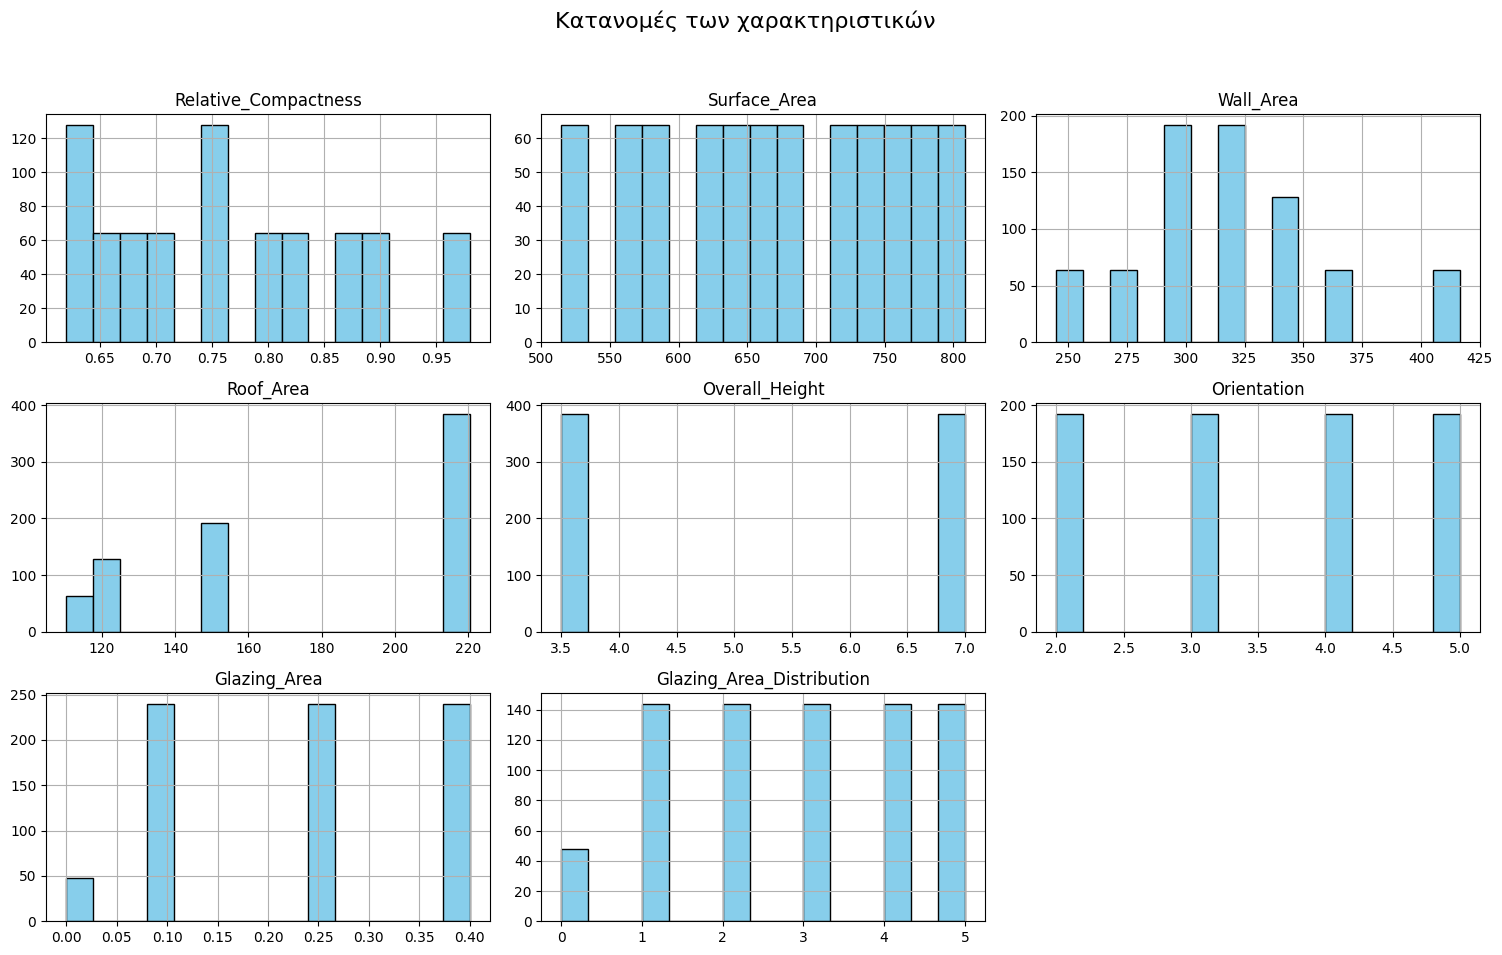

In [189]:
# Εμφάνιση histograms για τα 8 χαρακτηριστικά
df_features = df.iloc[:, :8]  # Τα 8 πρώτα columns

df_features.hist(bins=15, figsize=(15, 10), layout=(3, 3), color='skyblue', edgecolor='black')
plt.suptitle("Κατανομές των χαρακτηριστικών", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


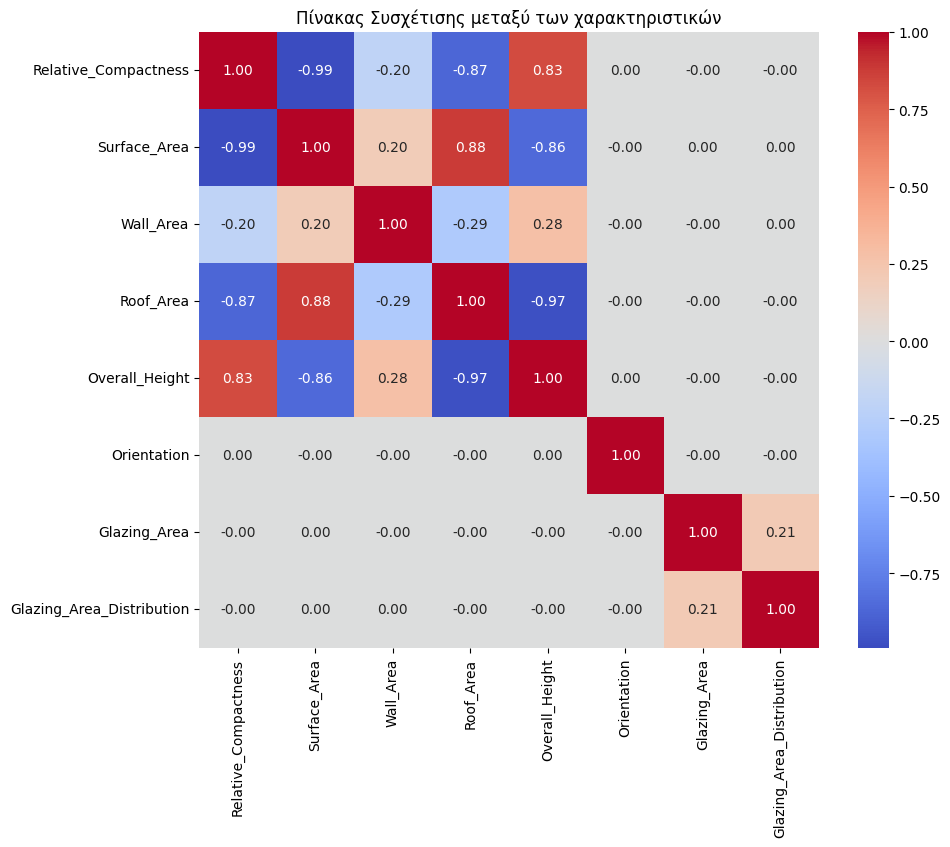

In [190]:
# Πίνακας συσχέτισης
plt.figure(figsize=(10, 8))
sns.heatmap(df.iloc[:, :8].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Πίνακας Συσχέτισης μεταξύ των χαρακτηριστικών")
plt.show()


### 3.1 Κατανομές των Αριθμητικών Χαρακτηριστικών

Παρακάτω παρουσιάζονται τα διαγράμματα κατανομής (histograms) για τα 8 χαρακτηριστικά του dataset. Με αυτό τον τρόπο εντοπίζονται οπτικά πιθανά outliers, ασυμμετρίες και οι γενικές τάσεις των δεδομένων.


### 3.2 Boxplots – Ανάλυση ανά χαρακτηριστικό

Ακολουθούν διαγράμματα τύπου boxplot για κάθε ένα από τα 8 χαρακτηριστικά του dataset.  
Σκοπός είναι να εντοπιστούν πιθανές ακραίες τιμές (outliers), η διάμεσος, και η κατανομή τιμών.


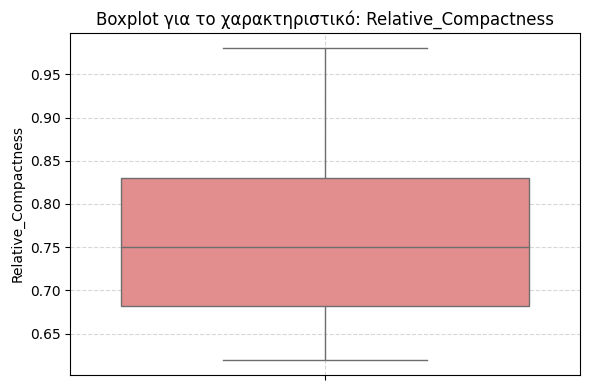

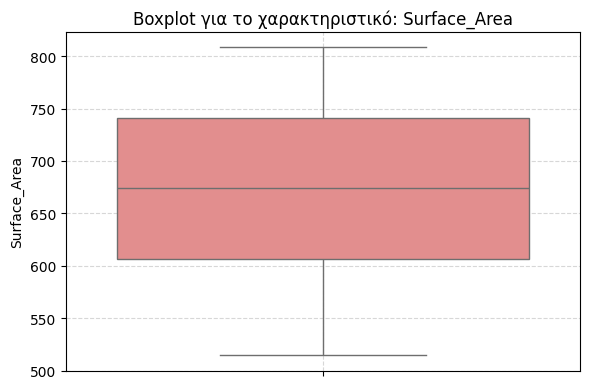

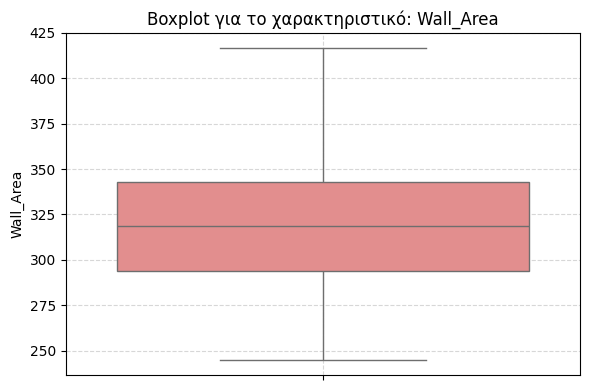

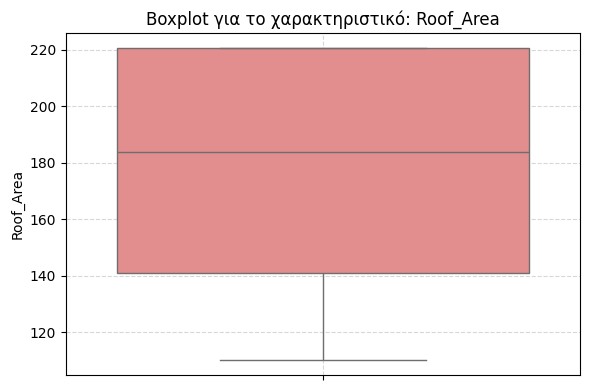

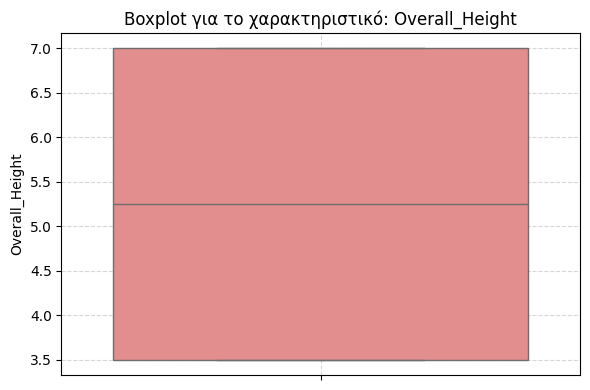

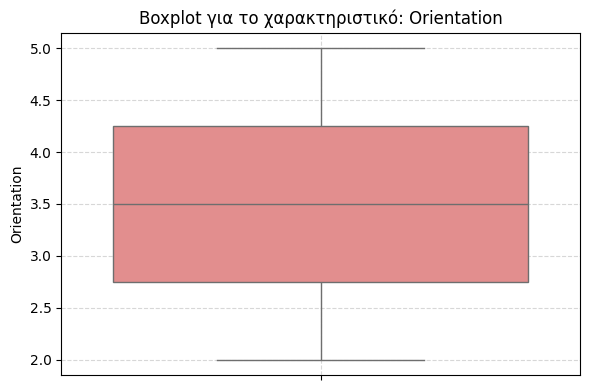

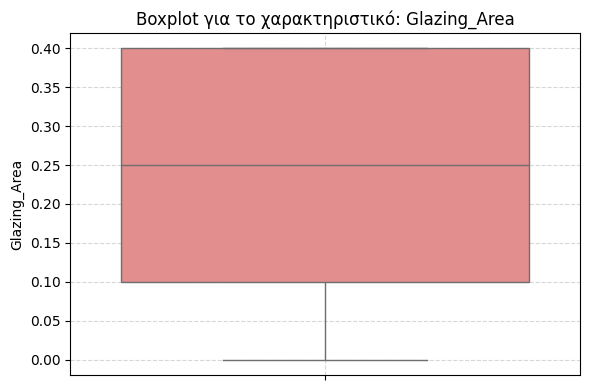

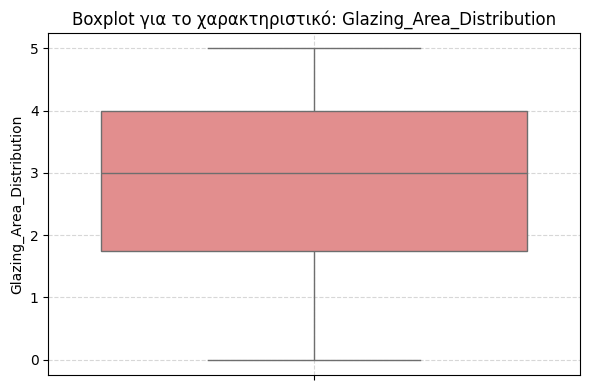

In [191]:
features = df.columns[:8]

for feature in features:
    plt.figure(figsize=(6, 4))
    sns.boxplot(y=df[feature], color='lightcoral')
    plt.title(f"Boxplot για το χαρακτηριστικό: {feature}")
    plt.ylabel(feature)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


### 3.3 Διαγράμματα κατανομής με πυκνότητα (Histogram + KDE)

Σε κάθε γράφημα απεικονίζεται η κατανομή ενός χαρακτηριστικού με τη μορφή ιστογράμματος, καθώς και μια καμπύλη πυκνότητας κατανομής (Kernel Density Estimation – KDE).


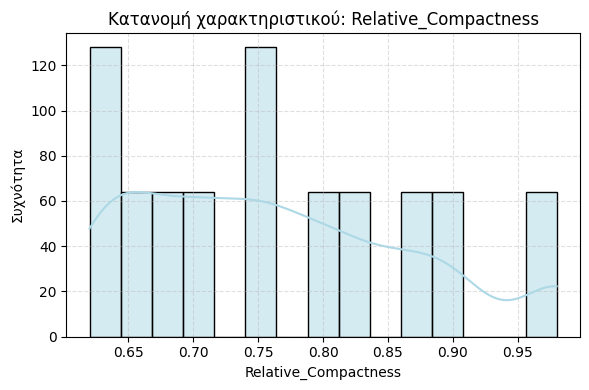

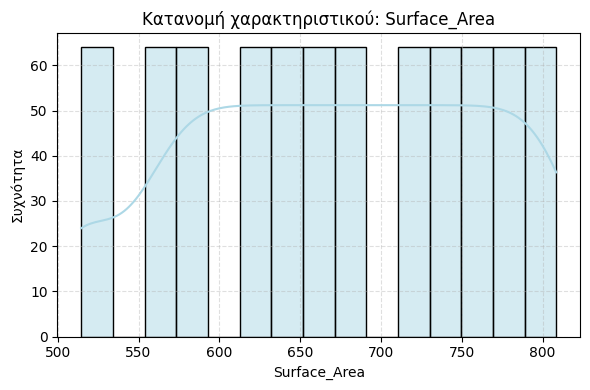

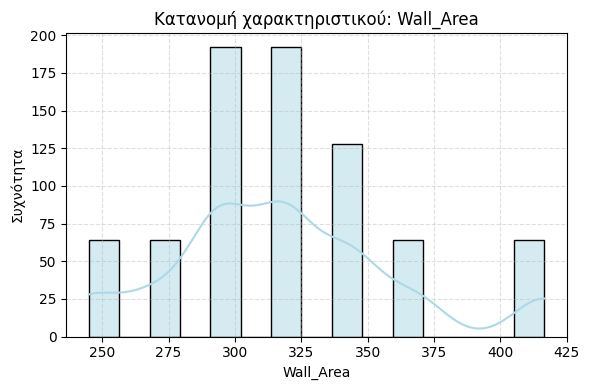

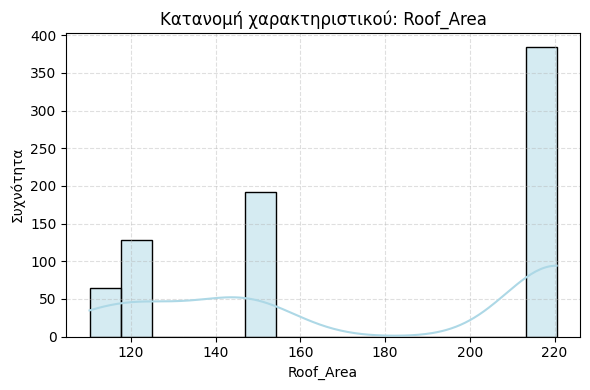

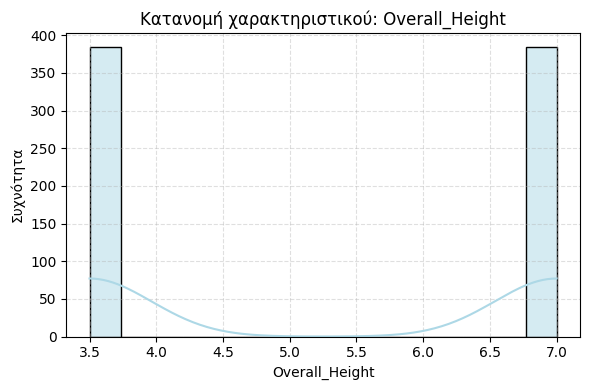

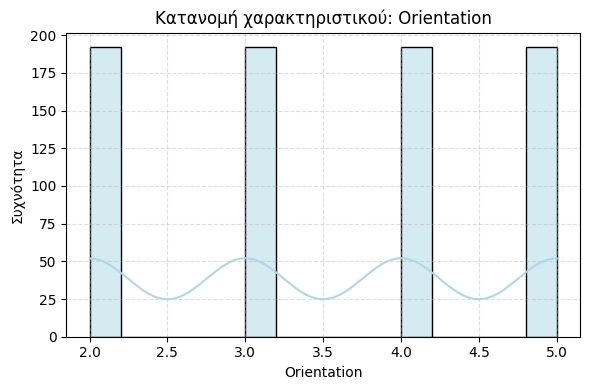

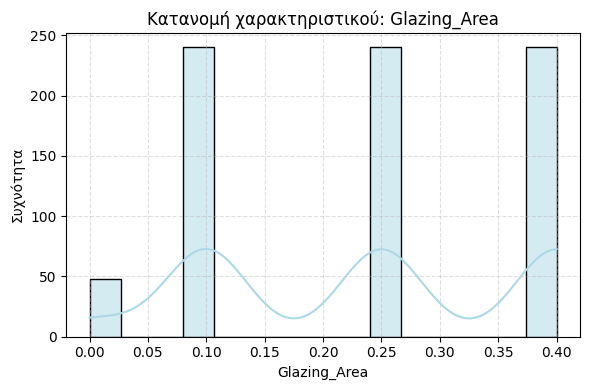

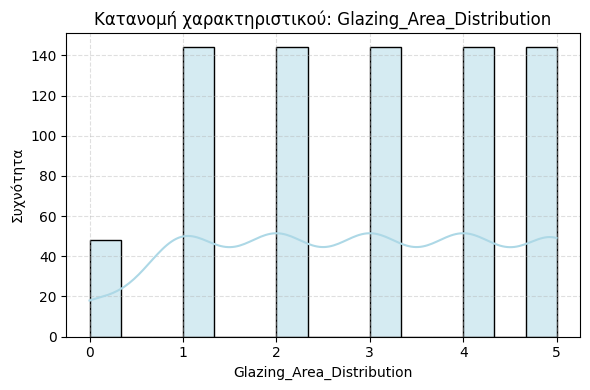

In [192]:
features = df.columns[:8]

for feature in features:
    plt.figure(figsize=(6, 4))
    sns.histplot(data=df, x=feature, bins=15, kde=True, color='lightblue')
    plt.title(f"Κατανομή χαρακτηριστικού: {feature}")
    plt.xlabel(feature)
    plt.ylabel("Συχνότητα")
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.show()


### 3.4 Περιγραφική Στατιστική των Χαρακτηριστικών

Ο παρακάτω πίνακας περιλαμβάνει συνοπτικά στατιστικά περιγραφής για τα 8 χαρακτηριστικά του dataset:

- Ελάχιστη και μέγιστη τιμή
- Μέση τιμή και διάμεσος (50%)
- Τυπική απόκλιση
- Τεταρτημόρια (25%, 75%)


In [193]:
# Περιγραφική στατιστική για τα 8 χαρακτηριστικά
df.iloc[:, :8].describe().T


,count,mean,std,min,25%,50%,75%,max
Relative_Compactness,768.0,0.764167,0.105777,0.62,0.6825,0.75,0.830,0.98
Surface_Area,768.0,671.708333,88.086116,514.50,606.3750,673.75,741.125,808.50
Wall_Area,768.0,318.500000,43.626481,245.00,294.0000,318.50,343.000,416.50
Roof_Area,768.0,176.604167,45.165950,110.25,140.8750,183.75,220.500,220.50
Overall_Height,768.0,5.250000,1.751140,3.50,3.5000,5.25,7.000,7.00
Orientation,768.0,3.500000,1.118763,2.00,2.7500,3.50,4.250,5.00
Glazing_Area,768.0,0.234375,0.133221,0.00,0.1000,0.25,0.400,0.40
Glazing_Area_Distribution,768.0,2.812500,1.550960,0.00,1.7500,3.00,4.000,5.00


## 4. Προετοιμασία για Συσταδοποίηση (Clustering)

### 4.1 Κανονικοποίηση Χαρακτηριστικών

Για τη σωστή εφαρμογή του αλγορίθμου KMeans, είναι σημαντικό όλα τα χαρακτηριστικά να βρίσκονται στην ίδια κλίμακα.  
Χρησιμοποιούμε τον StandardScaler ώστε κάθε χαρακτηριστικό να έχει μέση τιμή 0 και τυπική απόκλιση 1.


In [194]:
# Επιλογή μόνο των 8 αριθμητικών χαρακτηριστικών
X = df.iloc[:, :8]

# Κανονικοποίηση των χαρακτηριστικών
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


### 4.2 Επιλογή αριθμού clusters – Μέθοδος Elbow

Η μέθοδος Elbow βοηθά στον εντοπισμό του κατάλληλου αριθμού συστάδων (k)  
με βάση τη μεταβολή της ενδο-συσταδικής απόστασης (inertia).


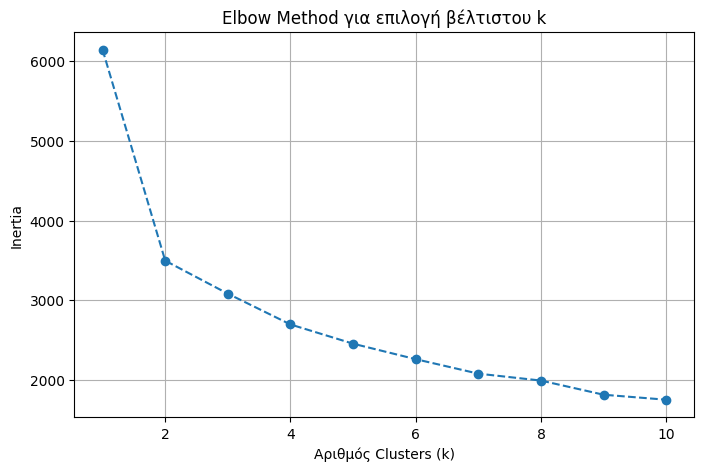

In [195]:
# Υπολογισμός inertia για διαφορετικές τιμές του k
inertias = []
K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

# Οπτικοποίηση Elbow Method
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertias, marker='o', linestyle='--')
plt.xlabel('Αριθμός Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method για επιλογή βέλτιστου k')
plt.grid(True)
plt.show()


### 4.3 Εφαρμογή KMeans για διαφορετικές τιμές k

Για σκοπούς σύγκρισης και αξιολόγησης, εφαρμόζεται ο αλγόριθμος KMeans για δύο διαφορετικές τιμές k:

- **k = 2**, ώστε να διαπιστώσουμε αν υπάρχει διαχωρισμός μεταξύ δύο βασικών ομάδων
- **k = 3**, τιμή που προτείνει η μέθοδος Elbow

Στη συνέχεια συγκρίνουμε τα αποτελέσματα των δύο συσταδοποιήσεων.


In [196]:
# KMeans για k = 2
kmeans_2 = KMeans(n_clusters=2, random_state=42)
clusters_2 = kmeans_2.fit_predict(X_scaled)
df["Cluster_k2"] = clusters_2

# KMeans για k = 3
kmeans_3 = KMeans(n_clusters=3, random_state=42)
clusters_3 = kmeans_3.fit_predict(X_scaled)
df["Cluster_k3"] = clusters_3

# Προβολή των πρώτων γραμμών
df.head()


,Relative_Compactness,Surface_Area,Wall_Area,Roof_Area,Overall_Height,Orientation,Glazing_Area,Glazing_Area_Distribution,Heating_Load,Cooling_Load,Cluster_k2,Cluster_k3
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33,1,1
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33,1,1
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33,1,1
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33,1,1
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28,1,1


## 5. Ανάλυση Συστάδων (Cluster Analysis)

Μετά την εφαρμογή του αλγορίθμου KMeans για k = 2 και k = 3, πραγματοποιούμε περιγραφική στατιστική ανάλυση των συστάδων.  
Αυτό μας βοηθά να κατανοήσουμε ποια χαρακτηριστικά διαφοροποιούν περισσότερο τις ομάδες.


### 5.1 Περιγραφική Ανάλυση για k = 2 και k = 3

Παρουσιάζεται ο μέσος όρος κάθε χαρακτηριστικού ανά cluster.


In [197]:
# Μέσες τιμές ανά cluster για k=2
df.groupby("Cluster_k2").mean(numeric_only=True).T


Cluster_k2,0,1
Relative_Compactness,0.676667,0.851667
Surface_Area,747.250000,596.166667
Wall_Area,306.250000,330.750000
Roof_Area,220.500000,132.708333
Overall_Height,3.500000,7.000000
Orientation,3.500000,3.500000
Glazing_Area,0.234375,0.234375
Glazing_Area_Distribution,2.812500,2.812500
Heating_Load,13.338516,31.275885
Cooling_Load,16.071432,33.104089


In [198]:
# Μέσες τιμές ανά cluster για k=3
df.groupby("Cluster_k3").mean(numeric_only=True).T


Cluster_k3,0,1,2
Relative_Compactness,0.676667,0.890000,0.775000
Surface_Area,747.250000,569.625000,649.250000
Wall_Area,306.250000,306.250000,379.750000
Roof_Area,220.500000,131.687500,134.750000
Overall_Height,3.500000,7.000000,7.000000
Orientation,3.500000,3.500000,3.500000
Glazing_Area,0.234375,0.234375,0.234375
Glazing_Area_Distribution,2.812500,2.812500,2.812500
Heating_Load,13.338516,28.345781,37.136094
Cooling_Load,16.071432,30.494492,38.323281


### 6. Οπτική Ανάλυση των Συστάδων 

### 6.1 Διαγράμματα Συσχέτισης (Pairplot) με Συστάδες

Το pairplot απεικονίζει τη συσχέτιση μεταξύ όλων των χαρακτηριστικών και χρωματίζει τα σημεία ανάλογα με τη συστάδα στην οποία ανήκουν.  
Αυτό μας βοηθά να εντοπίσουμε ποια χαρακτηριστικά διαχωρίζουν καλύτερα τις ομάδες.


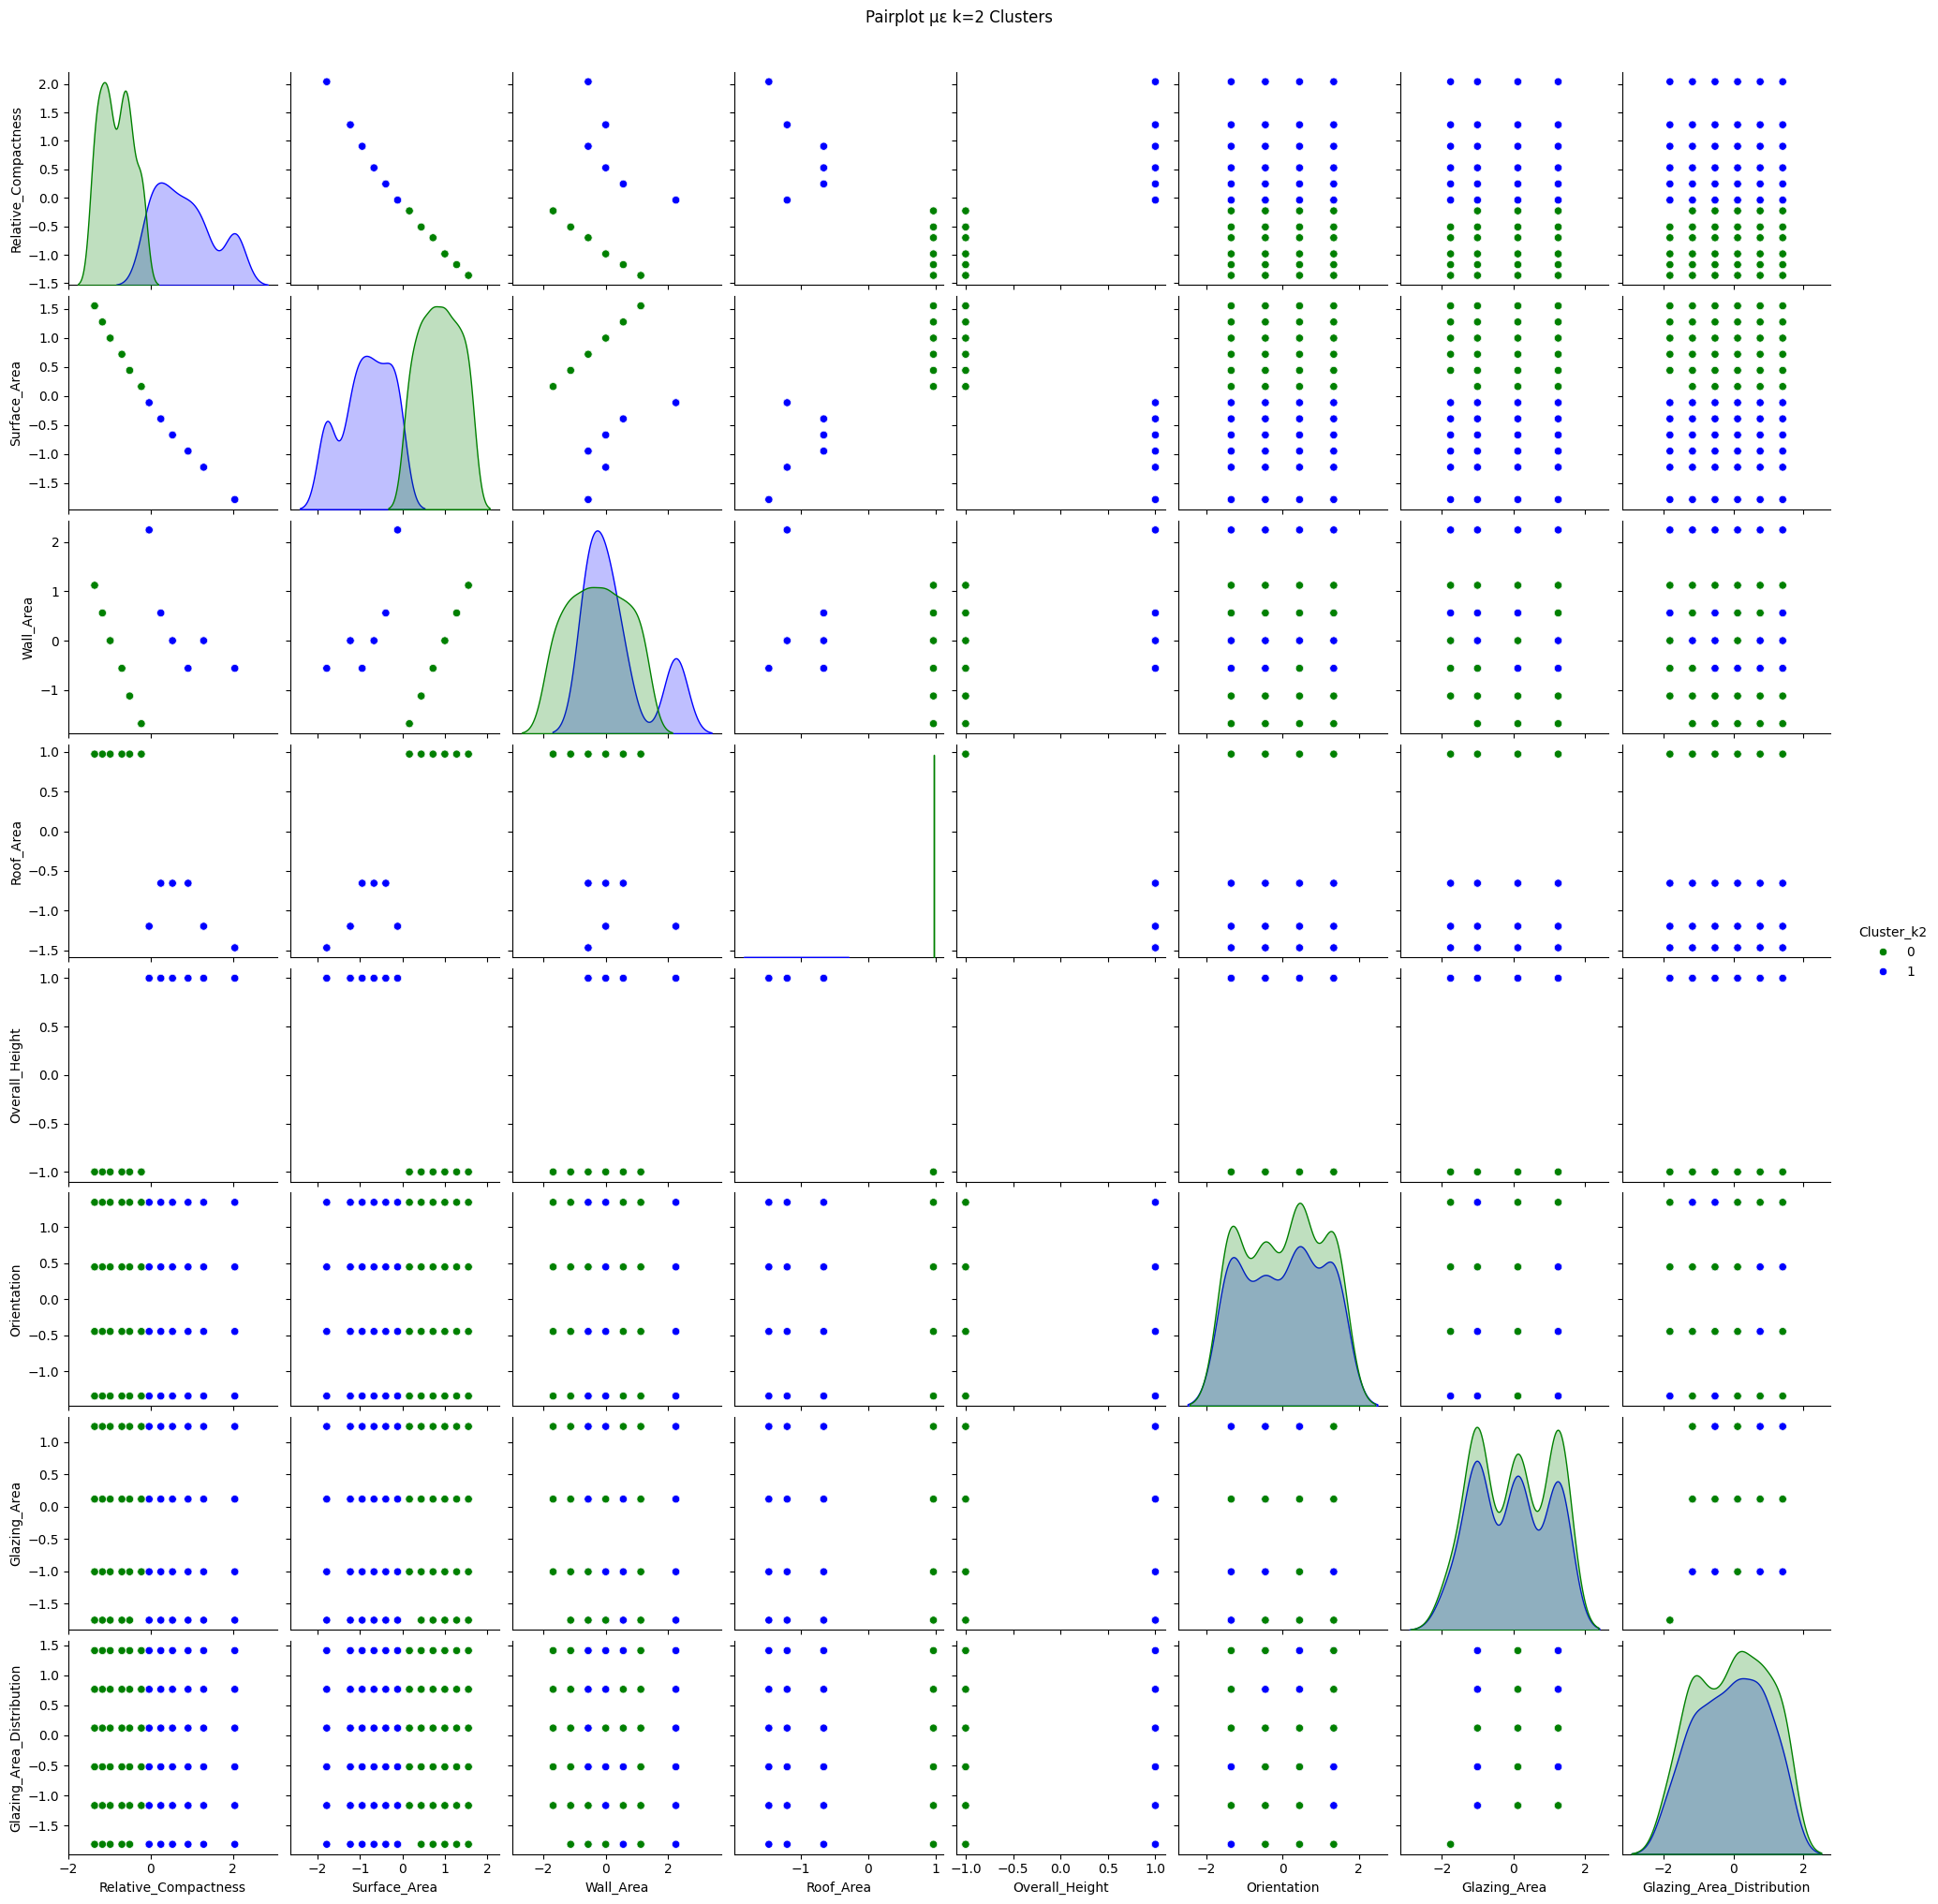

In [199]:
# Μειώνουμε λίγο το sample για ταχύτερη απεικόνιση
sample_df = df.sample(300, random_state=42)

# Χρησιμοποιούμε τα κανονικοποιημένα δεδομένα και προσθέτουμε τα clusters
pairplot_data = pd.DataFrame(X_scaled, columns=df.columns[:8])
pairplot_data["Cluster_k2"] = df["Cluster_k2"]

# Pairplot με χρώμα ανά cluster (k=2)
sns.pairplot(pairplot_data.sample(300), hue="Cluster_k2", palette=["green", "blue"])
plt.suptitle("Pairplot με k=2 Clusters", y=1.02)
plt.show()


/Users/georgektenas/mir_env/lib/python3.13/site-packages/seaborn/axisgrid.py:1513: UserWarning: 
The palette list has fewer values (2) than needed (3) and will cycle, which may produce an uninterpretable plot.
  func(x=vector, **plot_kwargs)
/Users/georgektenas/mir_env/lib/python3.13/site-packages/seaborn/axisgrid.py:1513: UserWarning: 
The palette list has fewer values (2) than needed (3) and will cycle, which may produce an uninterpretable plot.
  func(x=vector, **plot_kwargs)
/Users/georgektenas/mir_env/lib/python3.13/site-packages/seaborn/axisgrid.py:1513: UserWarning: 
The palette list has fewer values (2) than needed (3) and will cycle, which may produce an uninterpretable plot.
  func(x=vector, **plot_kwargs)
/Users/georgektenas/mir_env/lib/python3.13/site-packages/seaborn/axisgrid.py:1513: UserWarning: 
The palette list has fewer values (2) than needed (3) and will cycle, which may produce an uninterpretable plot.
  func(x=vector, **plot_kwargs)
/Users/georgektenas/mir_env/lib/

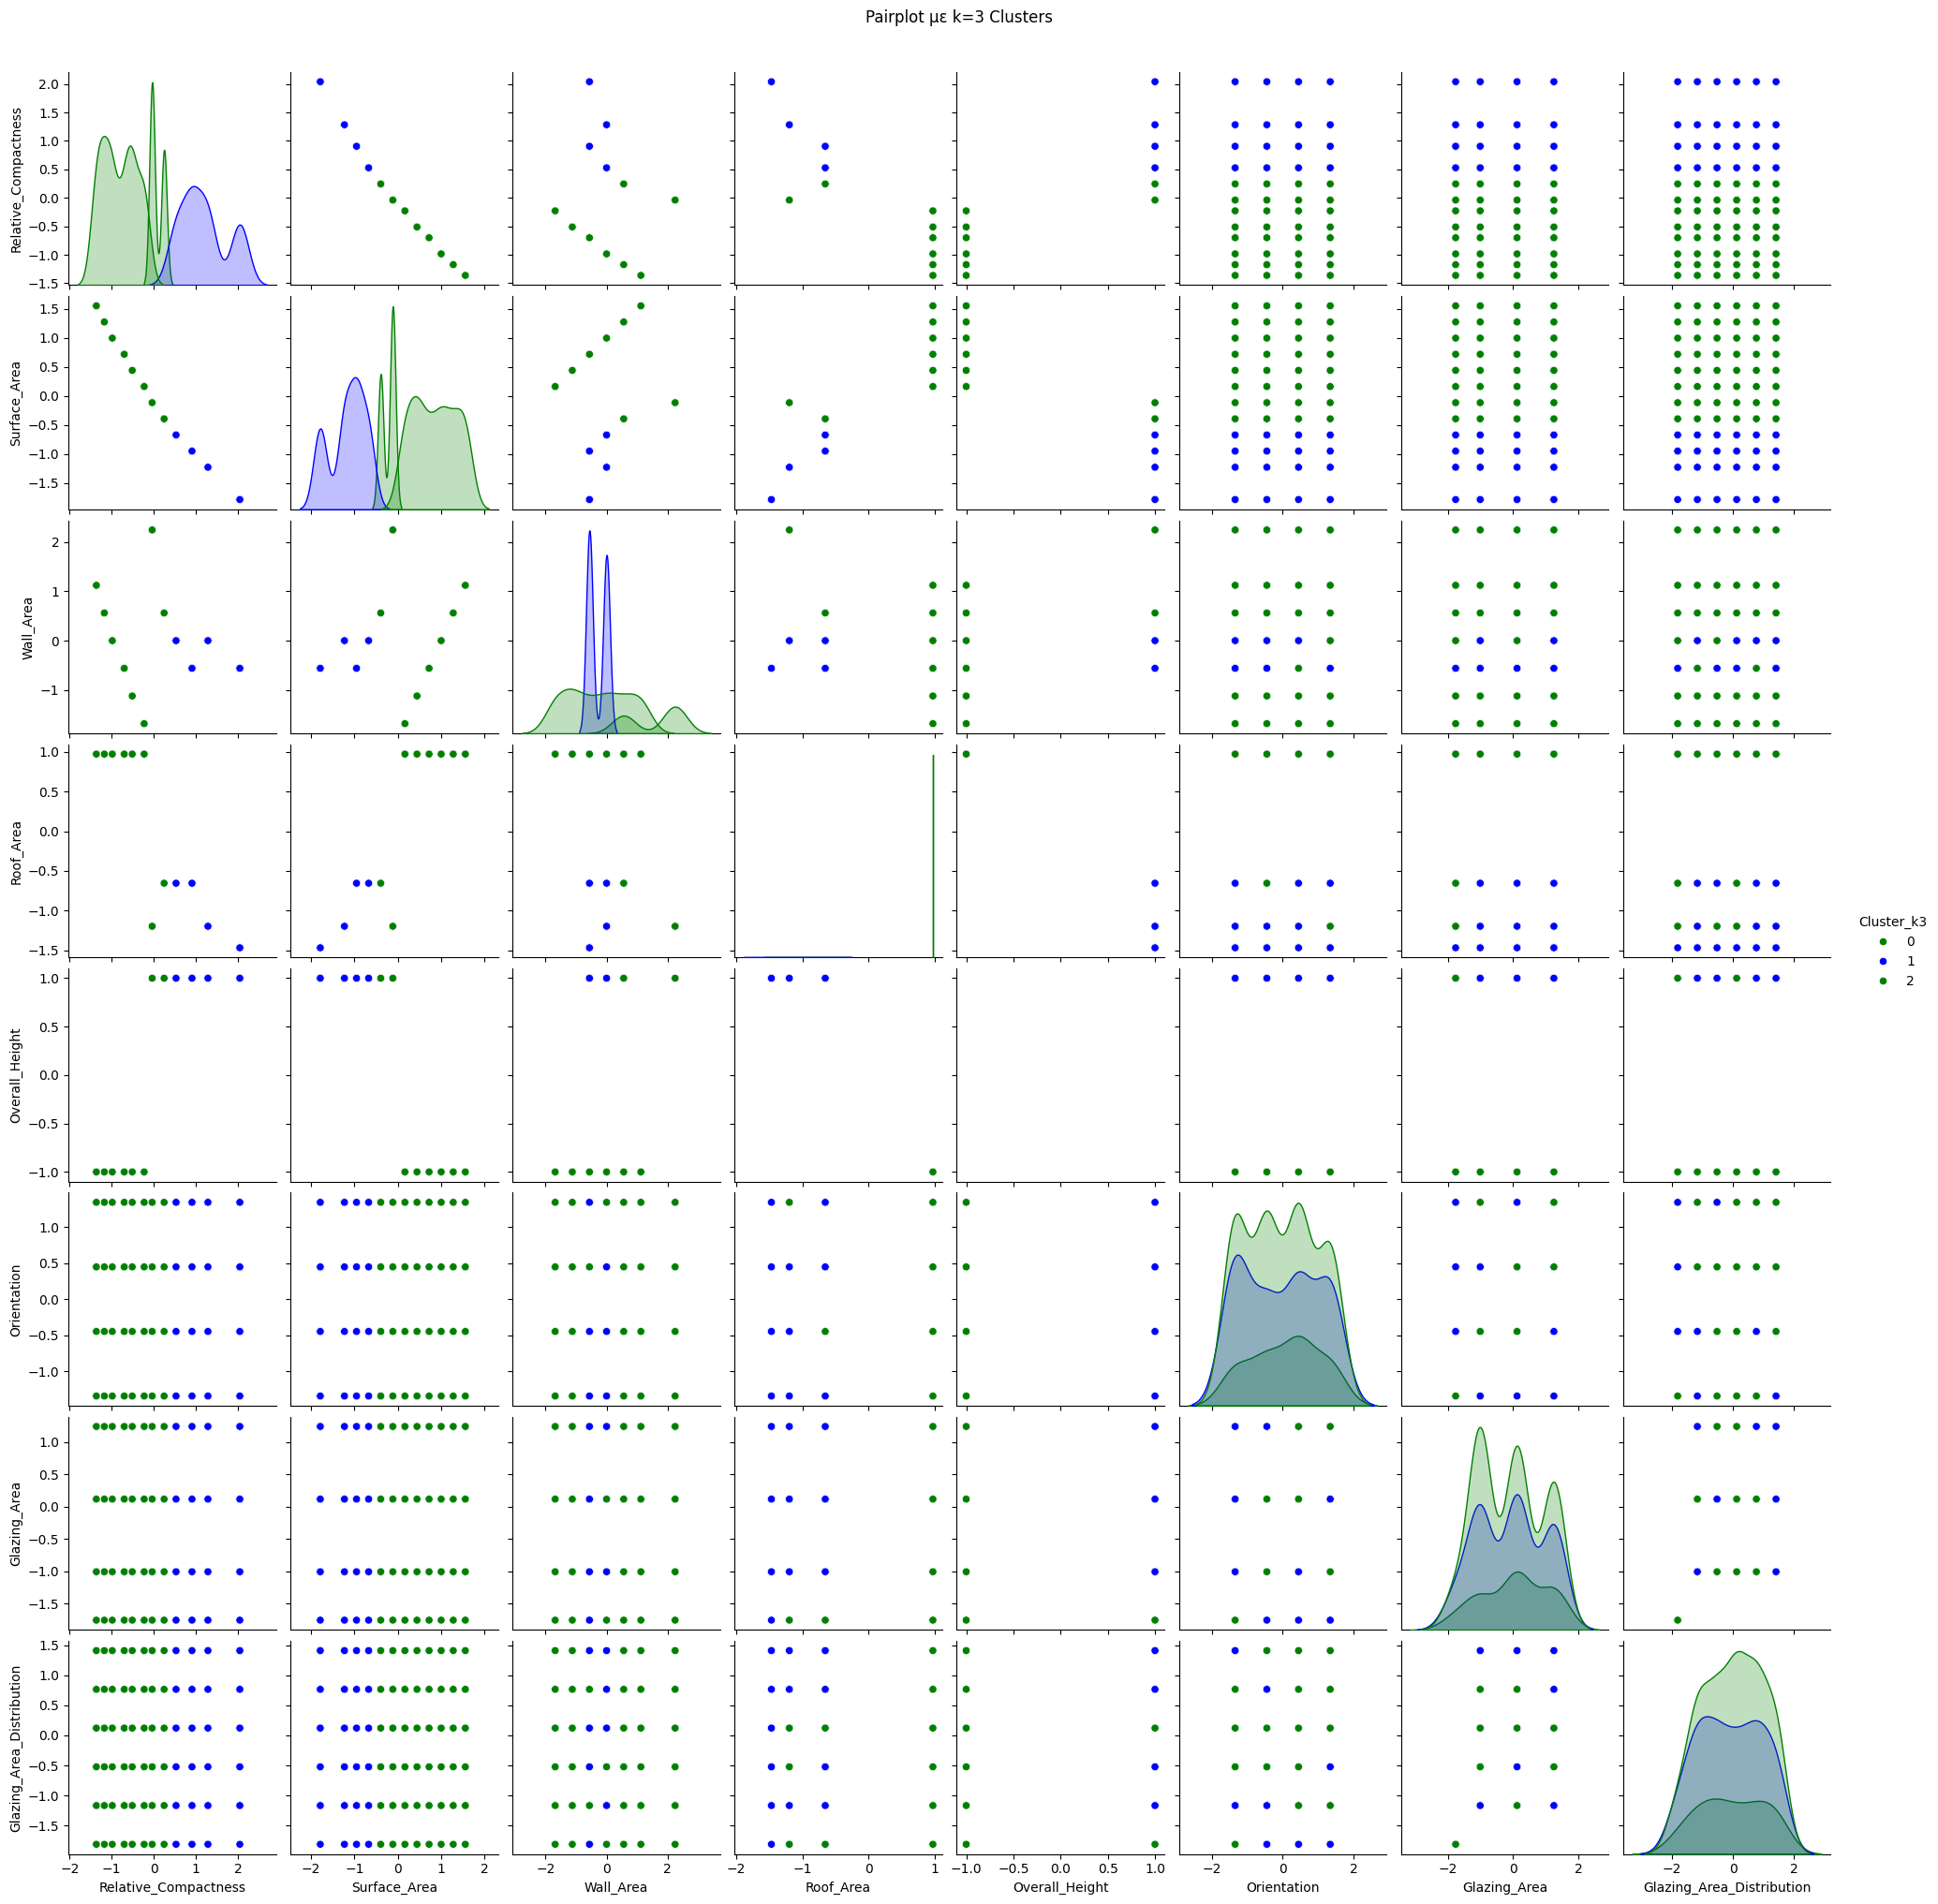

In [200]:
# Μειώνουμε λίγο το sample για ταχύτερη απεικόνιση
sample_df = df.sample(300, random_state=42)

# Χρησιμοποιούμε τα κανονικοποιημένα δεδομένα και προσθέτουμε τα clusters
pairplot_data = pd.DataFrame(X_scaled, columns=df.columns[:8])
pairplot_data["Cluster_k3"] = df["Cluster_k3"]

# Pairplot με χρώμα ανά cluster (k=2)
sns.pairplot(pairplot_data.sample(300), hue="Cluster_k3", palette=["green", "blue"])
plt.suptitle("Pairplot με k=3 Clusters", y=1.02)
plt.show()


### 6.2 Επιλεγμένα Διαγράμματα Διασποράς με βάση τον Πίνακα Συσχέτισης

Αφού εξετάσαμε το heatmap συσχέτισης, προσαρμόσαμε τις επιλογές μας ώστε να συμπεριλάβουμε ζεύγη μεταβλητών που είτε:

- παρουσιάζουν μέτρια ή χαμηλή συσχέτιση και άρα ενδέχεται να φανερώσουν κατηγοριοποίηση,
- είτε είναι κατηγορικές/κβαντισμένες μεταβλητές που διαφοροποιούν τις συστάδες.

Τα επιλεγμένα ζεύγη είναι:

1. `Wall_Area` vs `Roof_Area`
2. `Overall_Height` vs `Glazing_Area`
3. `Surface_Area` vs `Orientation`
4. `Glazing_Area_Distribution` vs `Orientation`


### Scatter Plots για k=2

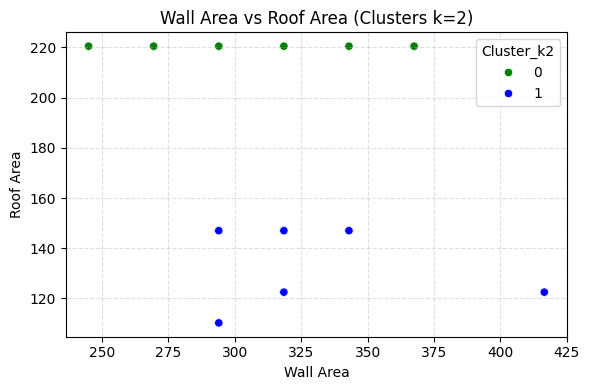

In [201]:
# 1. Wall area vs roof area 

plt.figure(figsize=(6, 4))
sns.scatterplot(data=df, x="Wall_Area", y="Roof_Area", hue="Cluster_k2", palette=["green", "blue"])
plt.title("Wall Area vs Roof Area (Clusters k=2)")
plt.xlabel("Wall Area")
plt.ylabel("Roof Area")
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()



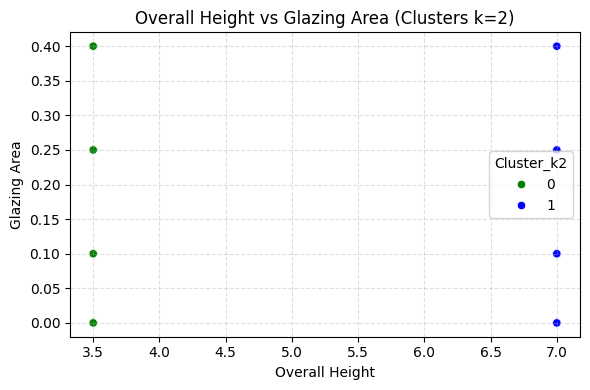

In [202]:
# 2. Overral Height vs glazing area

plt.figure(figsize=(6, 4))
sns.scatterplot(data=df, x="Overall_Height", y="Glazing_Area", hue="Cluster_k2", palette=["green", "blue"])
plt.title("Overall Height vs Glazing Area (Clusters k=2)")
plt.xlabel("Overall Height")
plt.ylabel("Glazing Area")
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


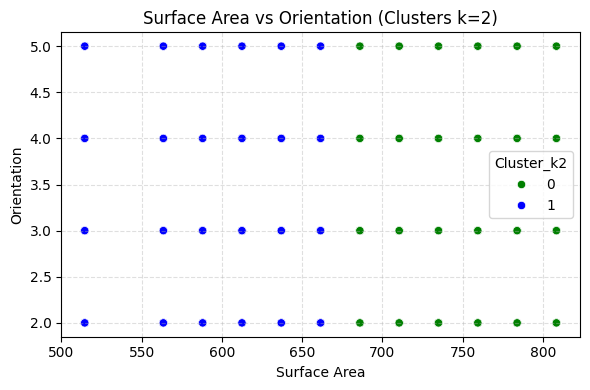

In [203]:
# 3. Surface area vs orientation

plt.figure(figsize=(6, 4))
sns.scatterplot(data=df, x="Surface_Area", y="Orientation", hue="Cluster_k2", palette=["green", "blue"])
plt.title("Surface Area vs Orientation (Clusters k=2)")
plt.xlabel("Surface Area")
plt.ylabel("Orientation")
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


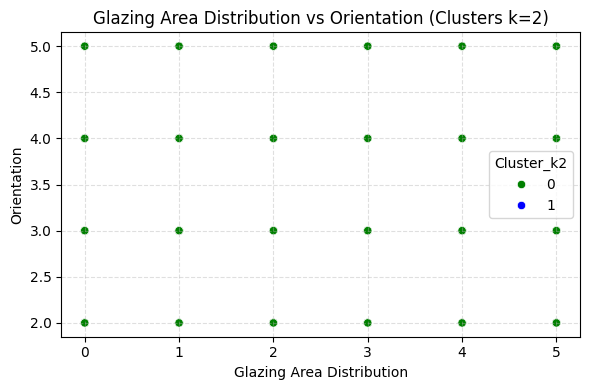

In [204]:
# 4. Glazing area vs orientation

plt.figure(figsize=(6, 4))
sns.scatterplot(data=df, x="Glazing_Area_Distribution", y="Orientation", hue="Cluster_k2", palette=["green", "blue"])
plt.title("Glazing Area Distribution vs Orientation (Clusters k=2)")
plt.xlabel("Glazing Area Distribution")
plt.ylabel("Orientation")
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


### Scatter Plots για k=3

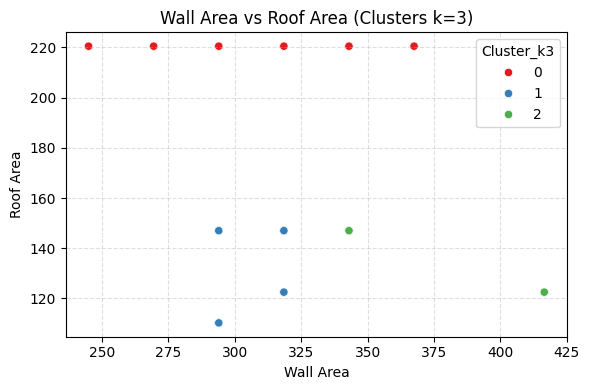

In [205]:
# 1. Wall area vs roof area 

plt.figure(figsize=(6, 4))
sns.scatterplot(data=df, x="Wall_Area", y="Roof_Area", hue="Cluster_k3", palette="Set1")
plt.title("Wall Area vs Roof Area (Clusters k=3)")
plt.xlabel("Wall Area")
plt.ylabel("Roof Area")
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()




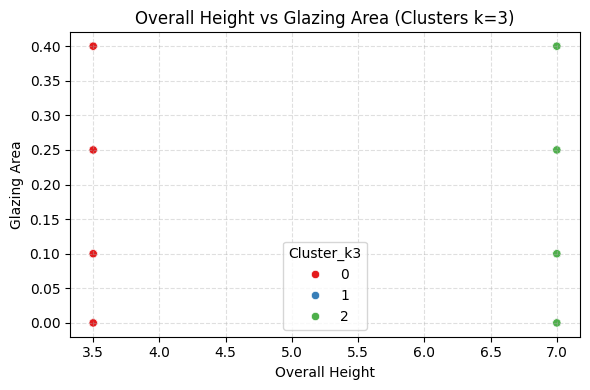

In [206]:
# 2. Overral Height vs glazing area

plt.figure(figsize=(6, 4))
sns.scatterplot(data=df, x="Overall_Height", y="Glazing_Area", hue="Cluster_k3", palette="Set1")
plt.title("Overall Height vs Glazing Area (Clusters k=3)")
plt.xlabel("Overall Height")
plt.ylabel("Glazing Area")
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


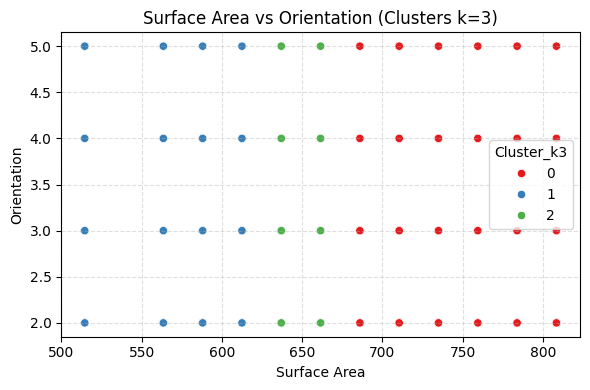

In [207]:
# 3. Surface area vs orientation

plt.figure(figsize=(6, 4))
sns.scatterplot(data=df, x="Surface_Area", y="Orientation", hue="Cluster_k3", palette="Set1")
plt.title("Surface Area vs Orientation (Clusters k=3)")
plt.xlabel("Surface Area")
plt.ylabel("Orientation")
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

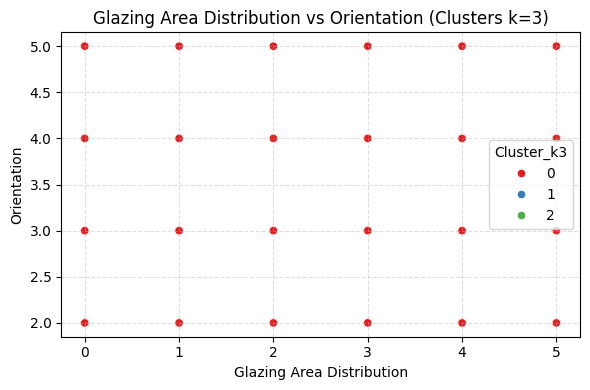

In [208]:
# 4. Glazing area vs orientation

plt.figure(figsize=(6, 4))
sns.scatterplot(data=df, x="Glazing_Area_Distribution", y="Orientation", hue="Cluster_k3", palette="Set1")
plt.title("Glazing Area Distribution vs Orientation (Clusters k=3)")
plt.xlabel("Glazing Area Distribution")
plt.ylabel("Orientation")
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


### 6.3 Σχολιασμός Scatter Plots

Από την οπτική απεικόνιση των 4 επιλεγμένων ζευγών χαρακτηριστικών με χρωματισμό ανά cluster (για k = 2 και k = 3), προκύπτουν τα εξής συμπεράσματα:

- Τα ζεύγη **Wall_Area vs Roof_Area**, **Overall_Height vs Glazing_Area**, και **Surface_Area vs Orientation** παρουσιάζουν **καλά διαχωρισμένους σχηματισμούς**, με εμφανή διαφοροποίηση μεταξύ των ομάδων. Ειδικά για το ύψος (`Overall_Height`), ο διαχωρισμός είναι απόλυτα ξεκάθαρος.
  
- Αντίθετα, το ζεύγος **Glazing_Area_Distribution vs Orientation** δεν επιφέρει κανέναν διαχωρισμό, καθώς όλα τα σημεία εντάσσονται στο ίδιο cluster. Αυτό δείχνει ότι οι δύο αυτές μεταβλητές πιθανόν δεν συνέβαλαν καθοριστικά στη συσταδοποίηση.

Συνολικά, τα scatter plots ενισχύουν την κατανόηση της εσωτερικής δομής των clusters και επιβεβαιώνουν ότι κάποιες μεταβλητές (π.χ. ύψος, εμβαδά) παίζουν σημαντικό ρόλο στον διαχωρισμό.


## 7. Οπτικοποίηση Συστάδων με PCA (Principal Component Analysis)

Η Ανάλυση Κύριων Συνιστωσών (PCA) εφαρμόζεται για να μειώσουμε τη διάσταση των δεδομένων από 8 σε 2 ή 3 άξονες, ώστε να οπτικοποιήσουμε τις συστάδες σε επίπεδο 2D και 3


In [209]:


# PCA με 2 και 3 συνιστώσες
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_scaled)

pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(X_scaled)

# Δημιουργία DataFrame με τα αποτελέσματα
df_pca = pd.DataFrame(X_pca_2d, columns=["PCA1", "PCA2"])
df_pca["Cluster_k2"] = df["Cluster_k2"]
df_pca["Cluster_k3"] = df["Cluster_k3"]


### 7.1 Διάγραμμα PCA 2D – Προβολή συστάδων

Παρακάτω φαίνεται η προβολή των παρατηρήσεων στον επίπεδο 2D χώρο των δύο πρώτων κύριων συνιστωσών, με χρώμα ανά συστάδα.


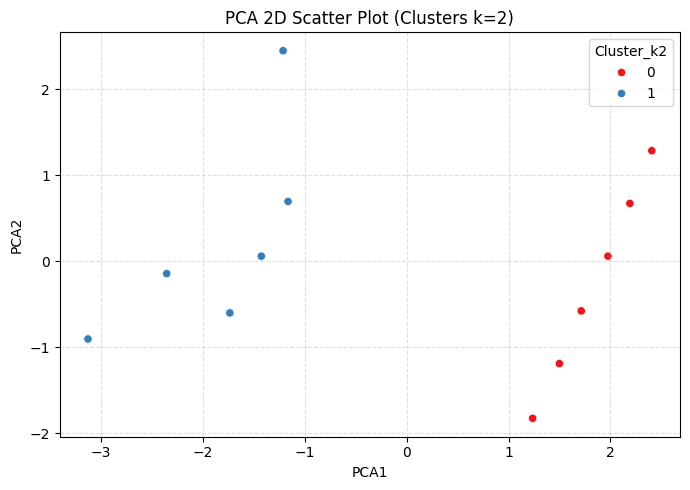

In [210]:
plt.figure(figsize=(7, 5))
sns.scatterplot(data=df_pca, x="PCA1", y="PCA2", hue="Cluster_k2", palette="Set1")
plt.title("PCA 2D Scatter Plot (Clusters k=2)")
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


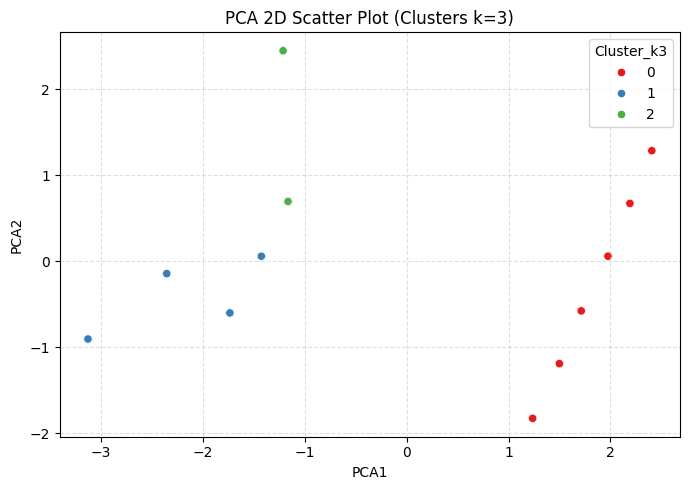

In [211]:
plt.figure(figsize=(7, 5))
sns.scatterplot(data=df_pca, x="PCA1", y="PCA2", hue="Cluster_k3", palette="Set1")
plt.title("PCA 2D Scatter Plot (Clusters k=3)")
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


### 7.2 Διάγραμμα PCA 3D – Τρισδιάστατη Οπτικοποίηση Συστάδων

Η τρισδιάστατη προβολή μέσω των πρώτων 3 κύριων συνιστωσών επιτρέπει την καλύτερη παρατήρηση της εσωτερικής δομής των συστάδων.  
Παρακάτω φαίνεται το scatter plot σε 3D, με χρωματισμό ανά cluster για k = 3.


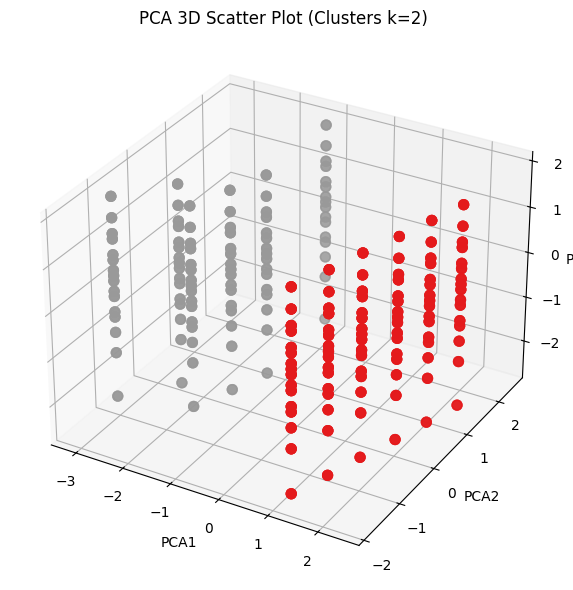

In [212]:


# Δημιουργία DataFrame με PCA 3D
df_pca_3d = pd.DataFrame(X_pca_3d, columns=["PCA1", "PCA2", "PCA3"])
df_pca_3d["Cluster_k2"] = df["Cluster_k2"]

# 3D scatter plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    df_pca_3d["PCA1"], df_pca_3d["PCA2"], df_pca_3d["PCA3"],
    c=df_pca_3d["Cluster_k2"], cmap="Set1", s=50
)

ax.set_xlabel("PCA1")
ax.set_ylabel("PCA2")
ax.set_zlabel("PCA3")
ax.set_title("PCA 3D Scatter Plot (Clusters k=2)")
plt.tight_layout()
plt.show()


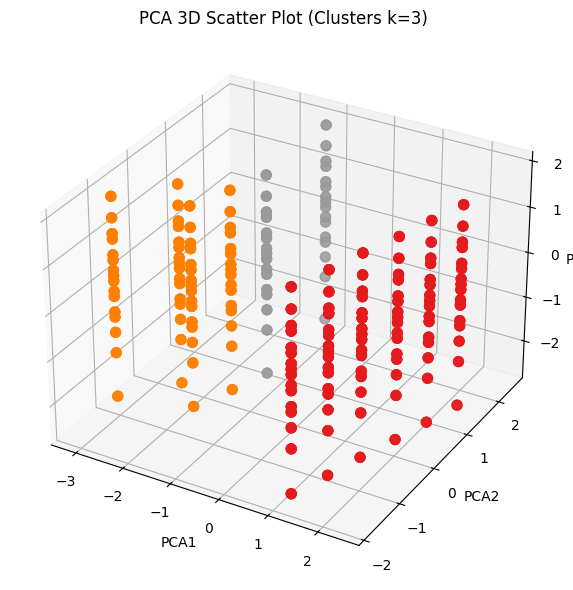

In [213]:


# Δημιουργία DataFrame με PCA 3D
df_pca_3d = pd.DataFrame(X_pca_3d, columns=["PCA1", "PCA2", "PCA3"])
df_pca_3d["Cluster_k3"] = df["Cluster_k3"]

# 3D scatter plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    df_pca_3d["PCA1"], df_pca_3d["PCA2"], df_pca_3d["PCA3"],
    c=df_pca_3d["Cluster_k3"], cmap="Set1", s=50
)

ax.set_xlabel("PCA1")
ax.set_ylabel("PCA2")
ax.set_zlabel("PCA3")
ax.set_title("PCA 3D Scatter Plot (Clusters k=3)")
plt.tight_layout()
plt.show()


### 7.3 Υπολογισμός Silhouette Score

Ο Silhouette Score είναι μετρική αξιολόγησης της ποιότητας ενός clustering.
Μετράει πόσο καλά "ταιριάζει" κάθε σημείο στο δικό του cluster σε σύγκριση με τα υπόλοιπα. 
- Κοντά στο +1 → καλή τοποθέτηση
- Κοντά στο 0 → σύνορα μεταξύ clusters
- Κοντά στο -1 → πιθανή λάθος ανάθεση

In [214]:


score_k2 = silhouette_score(X_scaled, df["Cluster_k2"])
score_k3 = silhouette_score(X_scaled, df["Cluster_k3"])

print(f"Silhouette Score for k=2: {score_k2:.4f}")
print(f"Silhouette Score for k=3: {score_k3:.4f}")


Silhouette Score for k=2: 0.3906
Silhouette Score for k=3: 0.2947


## 8. Final Thoughts

- Από την ανάλυση παρατηρούμε ότι **χαρακτηριστικά όπως το Overall Height και η Surface Area** έχουν σημαντική συνεισφορά στη συσταδοποίηση των κτιρίων.

- Με **k = 2**, τα δεδομένα χωρίζονται σε δύο γενικές ομάδες, που μπορούν να ερμηνευθούν ως:
  - Κτίρια με μεγαλύτερες ενεργειακές απαιτήσεις
  - Κτίρια με πιο αποδοτικά γεωμετρικά χαρακτηριστικά

- Με **k = 3**, η κατάτμηση γίνεται πιο λεπτομερής:
  - **Cluster 0**: υψηλό ύψος, μεγάλη συνολική επιφάνεια → ενδεχομένως πιο ενεργοβόρα κτίρια
  - **Cluster 1**: μέσες τιμές σε πολλά χαρακτηριστικά → ενδιάμεσης κατηγορίας
  - **Cluster 2**: μικρές διαστάσεις, πιθανή βελτιστοποίηση → πιθανή υψηλή ενεργειακή αποδοτικότητα

- Συνολικά, το clustering αποκαλύπτει **σαφείς υποομάδες κτιρίων** με κοινά γεωμετρικά/ενεργειακά πρότυπα, κάτι που μπορεί να αξιοποιηθεί για **ενεργειακή κατηγοριοποίηση ή προτάσεις εξοικονόμησης**.
